<a href="https://colab.research.google.com/github/arhaana/probable-memory/blob/main/BritishAirways.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [ ]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

In [ ]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

In [ ]:
df.to_csv("britishairways.csv")

Data Cleaning


In [ ]:
#imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

#regex
import re

In [ ]:
#create a dataframe from csv file

cwd = os.getcwd()

df = pd.read_csv(cwd+"/britishairways.csv", index_col=0)

In [ ]:
df.head()

,reviews
0,✅ Trip Verified | London Heathrow to Male In...
1,Not Verified | Very good flight following an ...
2,Not Verified | An hour's delay due to late ar...
3,✅ Trip Verified | I booked through BA becaus...
4,✅ Trip Verified | British airways lost bags ...


In [ ]:
df['verified'] = df.reviews.str.contains("Trip Verified")

In [ ]:
df['verified']

,verified
0,True
1,False
2,False
3,True
4,True
...,...
995,True
996,False
997,False
998,True


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob

In [ ]:
# Download necessary NLTK resources (if not already downloaded)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)


base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

for i in range(1, pages + 1):
    print(f"Scraping page {i}")
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    response = requests.get(url)
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    print(f"   ---> {len(reviews)} total reviews")

df = pd.DataFrame()
df["reviews"] = reviews


Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [ ]:
# Data Cleaning
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text, re.UNICODE) # Remove punctuation
    text = text.lower() # Lowercase
    text = [word for word in text.split() if word not in stopwords.words('english')] # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text] # Lemmatization
    text = " ".join(text)
    return text

df['cleaned_reviews'] = df['reviews'].apply(clean_text)

In [ ]:
# 2. Sentiment Analysis
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Returns polarity score (-1 to 1)

df['sentiment'] = df['cleaned_reviews'].apply(analyze_sentiment)

# Categorize sentiment
df['sentiment_label'] = df['sentiment'].apply(lambda score: 'positive' if score > 0 else 'negative' if score < 0 else 'neutral')

print(df['sentiment_label'].value_counts()) # Print sentiment distribution

sentiment_label
positive    625
negative    360
neutral      15
Name: count, dtype: int64


In [ ]:
# 3. Topic Modeling (LDA)
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english') # Can use the same stop words as above.
dtm = vectorizer.fit_transform(df['cleaned_reviews'])

num_topics = 5  # Adjust the number of topics as needed
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)


# Print top words for each topic
for i, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[-10:][::-1]  # Get indices of top 10 words
    top_words = [vectorizer.get_feature_names_out()[idx] for idx in top_words_idx]
    print(f"Topic {i+1}: {', '.join(top_words)}")

# Assign a dominant topic to each review (optional)
topic_distributions = lda.transform(dtm)
df['dominant_topic'] = topic_distributions.argmax(axis=1) + 1 # Adding 1 for topic numbering to start from 1.


Topic 1: voucher, refund, cancelled, customer, flight, travel, cancel, booked, ticket, week
Topic 2: flight, customer, cancelled, hour, ba, told, day, airport, british, london
Topic 3: flight, seat, ba, good, crew, service, food, class, trip, time
Topic 4: tel, aviv, road, pram, closure, frustratingly, m25, oslo, joked, bunch
Topic 5: wet, inability, hire, delivering, blame, personnel, sorted, commend, loading, engineer


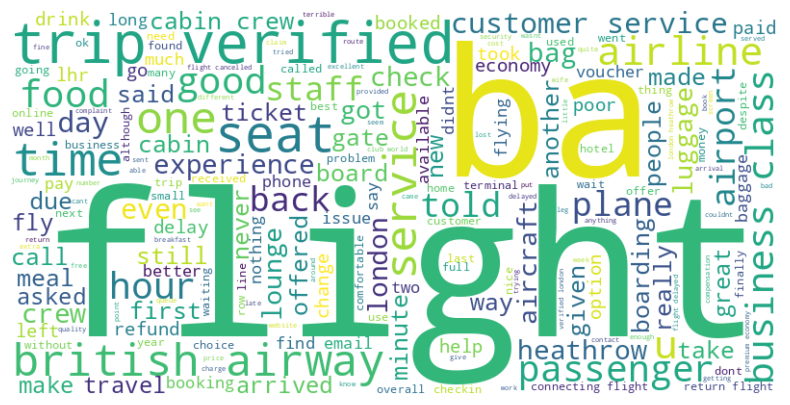

In [ ]:
# 1. Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned_reviews']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()